In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks
from datetime import datetime
import scipy.signal as signal
!pip install openpyxl==3.1.2

# Lab 06 - MATH/PHYS 241

Processing raw data to later be analyzed is one of the most important steps any scientist performs. There are a variety of methods to filter data and you will want to expose yourself to as many methods as possible so you are prepared for whatever comes your way.

Today, we will look at tidal time-series data collected by [NOAA and Woods Hole Oceanographic Institute](https://tidesandcurrents.noaa.gov/stationhome.html?id=8447930).

Upload "WHTides_2005_May_Data.xlsx" to the notebook as a pandas data frame. You can access todays datafile on CANVAS or my GitHub. Once uploaded, make sure to inspect the file. There are several columns with the following names:

* Station_ID
* Year
* Month
* Day
* Hour
* Minute
* Predicted_MLLW
* Verified_MLLW

MLLW stands for *mean lower low water* which represents the average value of the lowest tide over the recording period. Measurements are made every 6 minutes. This data set is complete for the month of May, 2005 (meaning there are no missing measurements).

# Decimal Date

When we plot time series data, it is very helpful if the x-axis is in a decimal date format instead of regular Julian Calendar day format. This allows us to more easily apply regression models since the slope will be over regular numbers instead of calendar numbers.

After you upload the data into a data frame, the first thing we need to do is calculate the decimal date. This is what we will want our x-axis to be when we make a plot of the MLLW vs Time.

To calculate the decimal date, you will need figure out a way to "sum" the time components into a single value. An easy way to do this is to find what the day number is and divide by total number of days in a year. For example, May 01 is the 121 day of the year (assuming it's not a leap-year), so we just divide 121 by 365 to get the decimal date.

This data set include Hours and Mintues. To find the fraction of a day including hours and minutes, we just need to take the hour divided by 24 and add the minute divided by (24 * 60). So, 15:06 on May 01, 2025 would be (6/(24*60) + 15/24 + 121)/365 + 2025 = 2025.3332306

## Q1

Calculate the Decimal Date for each data point, then plot Verified_MLLW vs Decimal Date.


In [54]:
# Upload CSV file
df = pd.read_excel('WHTides_2005_May_Data.xlsx')

# Smoothing Windows

When data is particularly noisy, it is sometimes necessary to smooth the data by applying a [smoothing window](https://en.wikipedia.org/wiki/Window_function). A smoothing window defines a set width called the window, then performs a function over data within the window and returns a single value.

There are many different types of smoothing windows to choose from, but two common ones are the [Boxcar Window](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.boxcar.html) and [Hamming Window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows).


The Boxcar window simply takes the average of all values within the window while the Hamming Window applies a cosine function and weights all of the values within the window depending on how far away they they are from the middle of the window before taking the sum.

The scipy library has a Boxcar function we may use:

`bc_window = scipy.signal.windows.boxcar(window_size)`

Where `window_size` is the length of the smoothing window.

The numpy library has a hamming function we may use:

`h_window = np.hamming(window_size)`

Lastly, we need to normalize the windows to ensure the weights assigned by the window sum to 1. This prevents the smoothing operation from changing the overall magnitude of the data. To do this, we can use:

`bc_window /= bc_window.sum()` \\
`h_window /= h_window.sum()`

Once we have the windows, the last step to to apply the smoothing window to the data. To do this, we have to [convolve](https://en.wikipedia.org/wiki/Convolution) the two arrays. Numpy again has a function we may use:

`smoothed_array = np.convolve(a , v, mode='same')`

Where `a` is the smoothing window and `v` is the data to be smoothed. Due to the way the smoothing works, the output will have a length $N+m-1$ where $N$ is the length of the unsmoothed data and $m$ is the length of the smoothing window. By including `mode='same'`, we tell python to exclude the added data points from the convolution.


## Q2

Using a smoothing window of 24 hours, smooth the Verified_MLLW data by apply a Boxcar and Hamming smoothing window and convolving.

Make a plot of the smoothed data (line plot '-') over the unsmoothed data (point plots '.'). Change the transparency of the unsmoothed data to `alpha = 0.25` so it is somewhat faded.

Is there a significant visual difference between the two methods? What happens if you zoom in on the x-axis? Does one method "better" preserve peaks than the other?

In [55]:
window_size = 10
boxcar_window = signal.windows.boxcar(window_size)
boxcar_window /= boxcar_window.sum()  # Normalize the window

hamming_window = np.hamming(window_size)
hamming_window /= hamming_window.sum()

# Apply convolution
Predicted_Smoothed_h = np.convolve(df['Predicted_MLLW'], hamming_window, mode='same')
Verified_Smoothed_h = np.convolve(df['Verified_MLLW'], hamming_window, mode='same')

Predicted_Smoothed_bc = np.convolve(df['Predicted_MLLW'], boxcar_window, mode='same')
Verified_Smoothed_bc = np.convolve(df['Verified_MLLW'], boxcar_window, mode='same')

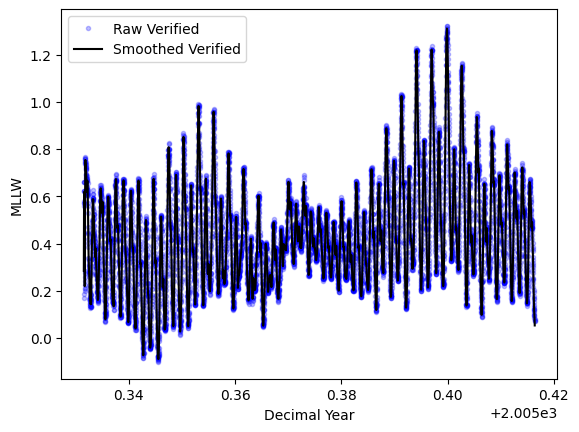

In [56]:
plt.plot(df['Dec_Date'], df['Verified_MLLW'], 'b.', alpha=0.25, label='Raw Verified')
plt.plot(df['Dec_Date'], Verified_Smoothed_h, 'k-', label='Smoothed Verified')


plt.xlabel('Decimal Year')
plt.ylabel('MLLW')
plt.legend()
plt.show()

# Periodograms

In class, we discussed the idea of Power Spectral Density and made plots to visually display the information. A [periodogram](https://en.wikipedia.org/wiki/Periodogram) is an estimate of the power spectral density and is often used to more quickly evaluate the power associated with specific frequencies present in a signal.

Importantly, the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html) has a function to help us make a periodogram very easily:

`f, Pxx = scipy.signal.periodogram(signal, sr)`

Where `signal` is the input signal (in time space) we would like to create the periodogram from and `sr` is the sample rate (in hertz).

The output of the function goes into two values, `f` and `Pxx`, which store the frequencies (x-axis) and the power (y-axis).

## Q3

Create 3 periodograms, one for the raw (unsmoothed) data, one for the boxcar window smoothed data, and one for the hamming window smoothed data. Make sure you give the sample rate in hertz!

Compare the plots. What diffences are noticable? How important is applying a smoothing window to the data?

What frequencies have significant peaks associated with them? What time (in hours) do these frequencies correspond to?  



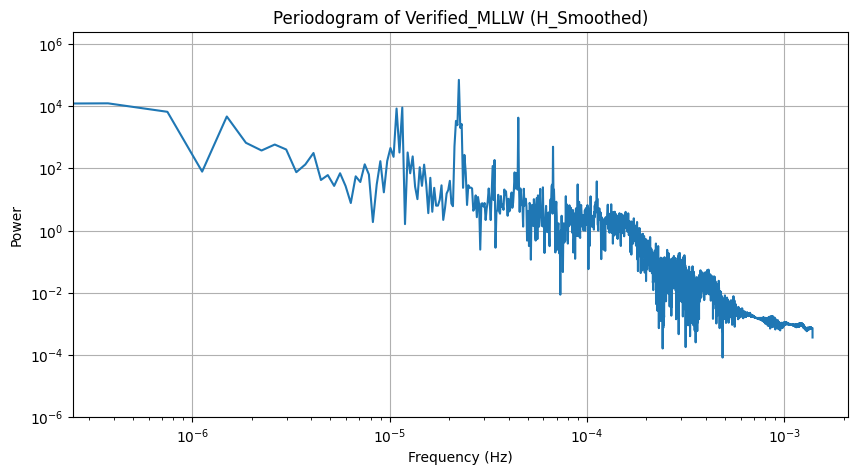

In [57]:
# Sampling frequency (Hz)
fs = 1 / (6 * 60)  # 1 sample every 360 seconds

# Compute periodogram
f_h, Pxx_h = periodogram(Verified_Smoothed_h, fs=fs)

# Start plot with frequency on the bottom
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot frequency vs power
ax1.plot(f_h, Pxx_h)
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_yscale('log')
ax1.set_ylabel('Power')
ax1.set_ylim(bottom=1e-6)
ax1.set_title('Periodogram of Verified_MLLW (H_Smoothed)')
ax1.grid(True)

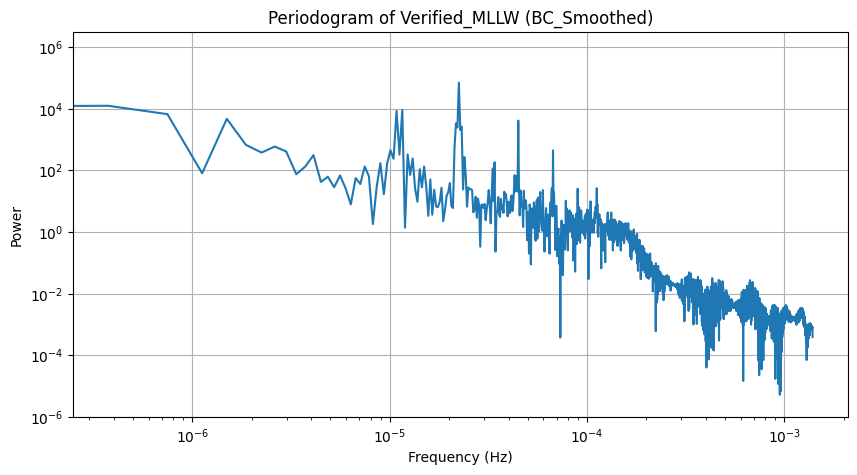

In [58]:
# Compute periodogram
f_bc, Pxx_bc = periodogram(Verified_Smoothed_bc, fs=fs)

# Start plot with frequency on the bottom
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot frequency vs power
ax1.plot(f_bc, Pxx_bc)
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_yscale('log')
ax1.set_ylabel('Power')
ax1.set_ylim(bottom=1e-6)
ax1.set_title('Periodogram of Verified_MLLW (BC_Smoothed)')
ax1.grid(True)

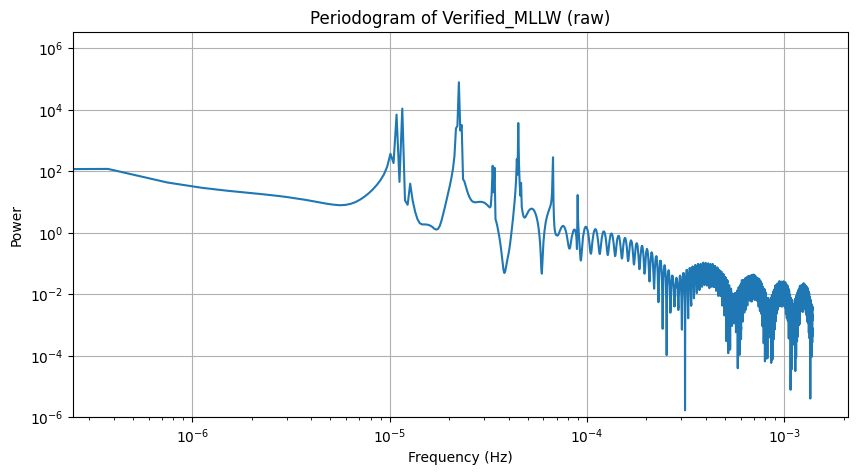

In [59]:
# Compute periodogram
f_raw, Pxx_raw = periodogram(df['Predicted_MLLW'], fs=fs)

# Start plot with frequency on the bottom
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot frequency vs power
ax1.plot(f_raw, Pxx_raw)
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_yscale('log')
ax1.set_ylabel('Power')
ax1.set_ylim(bottom=1e-6)
ax1.set_title('Periodogram of Verified_MLLW (raw)')
ax1.grid(True)

# Pre-whitening Data

The analysis we just performed is fine, but if we are trying to be thorough, then we should *pre-whiten* then data. This is usually simply the task of removing any long-term trends and the mean
from the data. Long-term trends represent more power at low frequencies (hence a “red” spectrum), and removing them “whitens” the spectrum.

As usual, there are many methods to do this and the exact method you want to implement will depend exactly on what type of data you have. For us, we will apply a linear fit the the data and remove the trend. Put another way, we want to calculate the residuals to the linear fit and redo the above analysis.

## Q4

Apply a linear fit to the raw data and find the residuals of the data to the fit. Using these residuals, apply the boxcar and hamming smoothing windows to smooth the data, then produce the periodograms for the pre-whitened smoothed data.

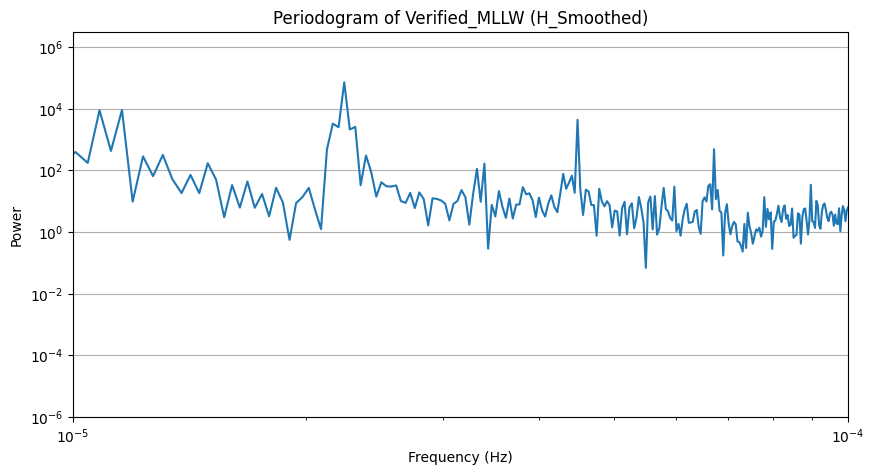

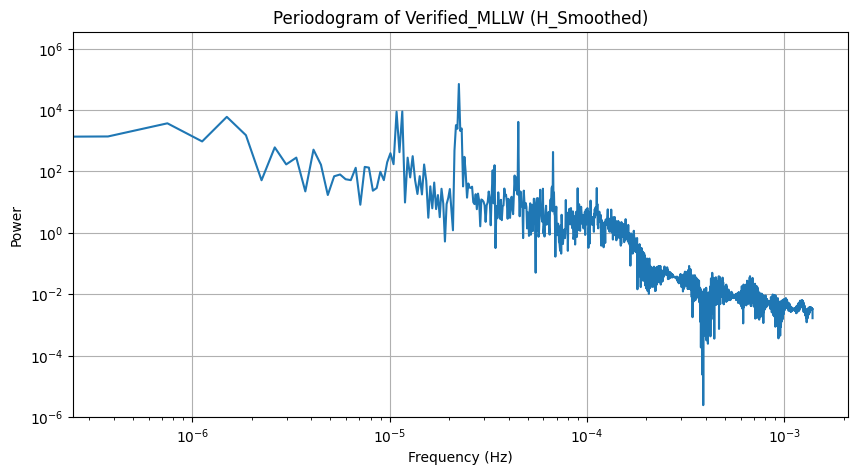

In [61]:
# Q4: Pre-whitening and Periodograms of Pre-whitened data
# Linear fit to raw data
slope, intercept = np.polyfit(df['Dec_Date'], df['Verified_MLLW'], 1)
linear_fit = slope * df['Dec_Date'] + intercept
residuals = df['Verified_MLLW'] - linear_fit

# Smooth the residuals
residuals_smoothed_h = np.convolve(residuals, hamming_window, mode='same')
residuals_smoothed_bc = np.convolve(residuals, boxcar_window, mode='same')

# Periodograms of smoothed residuals
f_res_h, Pxx_res_h = periodogram(residuals_smoothed_h, fs=fs)
f_res_bc, Pxx_res_bc = periodogram(residuals_smoothed_bc, fs=fs)

# Start plot with frequency on the bottom
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot frequency vs power
ax1.plot(f_res_h, Pxx_res_h)
ax1.set_xscale('log') # This line is already present in your code!
ax1.set_xlabel('Frequency (Hz)')
ax1.set_yscale('log')
ax1.set_ylabel('Power')
ax1.set_ylim(bottom=1e-6)
ax1.set_xlim(left = 1e-5, right = 1e-4)
ax1.set_title('Periodogram of Verified_MLLW (H_Smoothed)')
ax1.grid(True)
plt.show()

# Start plot with frequency on the bottom
fig, ax2 = plt.subplots(figsize=(10, 5))

# Plot frequency vs power
ax2.plot(f_res_bc, Pxx_res_bc)
ax2.set_xscale('log') # This line is already present in your code!
ax2.set_xlabel('Frequency (Hz)')
ax2.set_yscale('log')
ax2.set_ylabel('Power')
ax2.set_ylim(bottom=1e-6)
ax2.set_title('Periodogram of Verified_MLLW (H_Smoothed)')
ax2.grid(True)
plt.show()


In [ ]:
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks

# Estimate noise floor — you can take the median or a robust lower percentile
noise_floor = np.median(Pxx_h)

# Set significance level
alpha = 0.01  # 99% confidence

# Chi-squared threshold with 2 degrees of freedom
threshold = noise_floor * chi2.ppf(1 - alpha, df=2)

# Find peaks
peaks, _ = find_peaks(Pxx_h, height=threshold)

# Frequencies and periods of significant peaks
sig_freqs = f[peaks]
sig_powers = Pxx[peaks]
sig_periods = 1 / sig_freqs / 3600

plt.figure(figsize=(10, 5))
plt.plot(f_h, Pxx_h, label='Periodogram')
plt.axhline(threshold, color='red', linestyle='--', label=f'{(1-alpha)*100:.0f}% Significance Threshold')
plt.plot(sig_freqs, sig_powers, 'ro', label='Significant Peaks')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Significance Testing of Periodogram Peaks')
plt.legend()
plt.grid(True)